In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [4]:
WDIR = '/content/drive/MyDrive/_MVA/Smartflat/'
raw_data = pd.read_excel(WDIR + 'Metrics par patient.xlsx')

In [5]:
raw_data.head()

,Identité,Participant,Class,Age,Sexe,diagnostic,Average duration of whole fixations,Number of whole fixations,Number of saccades,Average peak velocity of saccades,...,Maximum amplitude of saccades,Total amplitude of saccades,Time to first saccade,Direction of first saccade,Peak velocity of first saccade,Average velocity of first saccade,Amplitude of first saccade,Minimum peak velocity of saccades,Maximum peak velocity of saccades,Standard deviation of peak velocity of saccades
0,G1_C1_BARMar_22022017,1.0,Contrôle,29,F,Contrôle,200.0,2290.0,1244.0,139.09,...,31.40,5398.52,105.0,31.46,280.42,161.24,6.71,30.04,825.81,120.94
1,G2_P1_LEBAla_23022017,2.0,Patient,57,H,LPR,124.0,1555.0,427.0,106.42,...,18.88,908.94,375.0,39.24,81.61,75.67,1.79,30.00,1416.50,124.05
2,G3_C2_FORCla_27022017,3.0,Contrôle,40,F,Contrôle,243.0,3979.0,2909.0,183.33,...,30.50,13601.63,775.0,270.97,228.32,153.85,6.33,30.02,1240.43,144.64
3,G4_P2_CHANic_02032017,4.0,Patient,67,F,LPR,180.0,2178.0,904.0,111.46,...,35.74,2196.99,8606.0,58.69,33.41,33.41,0.52,30.02,1682.88,175.61
4,G5_C3_FAKAzi_03032017,5.0,Contrôle,70,H,Contrôle,323.0,3497.0,2572.0,136.58,...,36.56,11451.62,245.0,166.80,265.57,154.23,7.61,30.05,898.65,115.26


In [6]:
features = raw_data.iloc[:, 7:]
features = features.drop(columns=['Lunettes', 'BNP', 'Score Gateau'])
features.head()

,Number of whole fixations,Number of saccades,Average peak velocity of saccades,Average amplitude of saccades,Interval duration,Total duration of whole fixations,Duration of first whole fixation,Minimum amplitude of saccades,Maximum amplitude of saccades,Total amplitude of saccades,Time to first saccade,Direction of first saccade,Peak velocity of first saccade,Average velocity of first saccade,Amplitude of first saccade,Minimum peak velocity of saccades,Maximum peak velocity of saccades,Standard deviation of peak velocity of saccades
0,2290.0,1244.0,139.09,4.34,1742640.0,456931.0,110.0,0.51,31.40,5398.52,105.0,31.46,280.42,161.24,6.71,30.04,825.81,120.94
1,1555.0,427.0,106.42,2.13,2476972.0,192170.0,320.0,0.32,18.88,908.94,375.0,39.24,81.61,75.67,1.79,30.00,1416.50,124.05
2,3979.0,2909.0,183.33,4.68,1441998.0,966244.0,160.0,0.30,30.50,13601.63,775.0,270.97,228.32,153.85,6.33,30.02,1240.43,144.64
3,2178.0,904.0,111.46,2.43,2499000.0,392181.0,110.0,0.13,35.74,2196.99,8606.0,58.69,33.41,33.41,0.52,30.02,1682.88,175.61
4,3497.0,2572.0,136.58,4.45,1655932.0,1129768.0,140.0,0.51,36.56,11451.62,245.0,166.80,265.57,154.23,7.61,30.05,898.65,115.26


0      True
1      True
2      True
3      True
4      True
      ...  
81    False
82    False
83     True
84     True
85     True
Name: diagnostic, Length: 86, dtype: bool

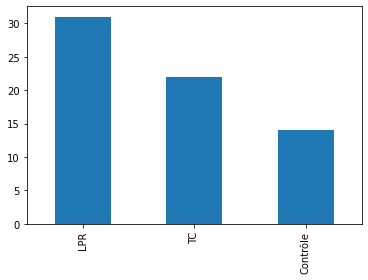

In [46]:
target = raw_data.loc[raw_data['diagnostic'].isin(['LPR', 'TC', 'Contrôle']), 'diagnostic']
target.value_counts().plot(kind='bar')

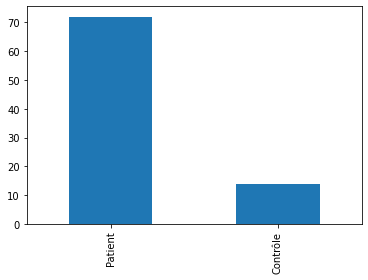

In [7]:
target = raw_data.loc[:, 'Class']
target.value_counts().plot(kind='bar')

In [64]:
X = features.loc[raw_data['diagnostic'].isin(['LPR', 'TC', 'Contrôle'])].dropna(how='any')
y = target.loc[X.index]

X = (X - X.min()) / (X.max()-X.min())

le = LabelEncoder()
y = le.fit_transform(y)

## Logistic Regression feature importances

In [65]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X, y)

accuracy_score(y, clf.predict(X))

0.639344262295082

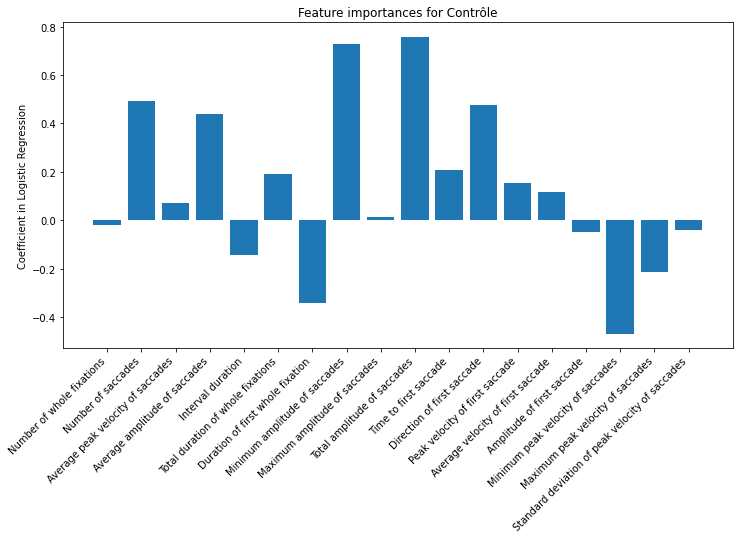

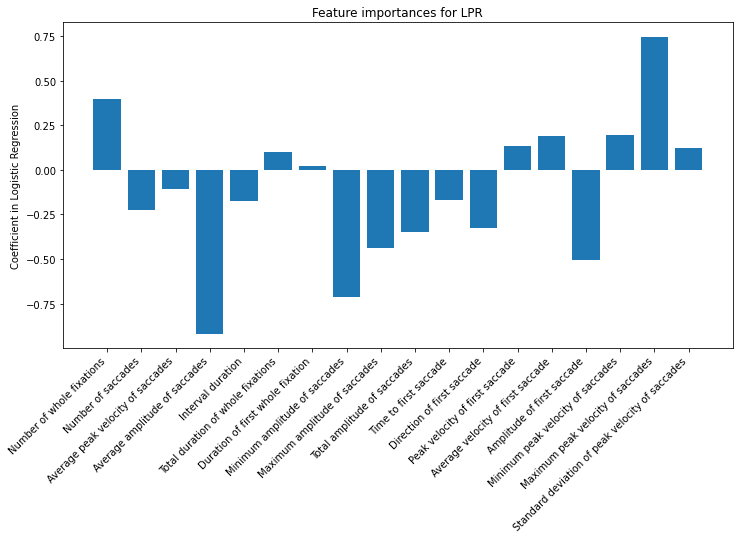

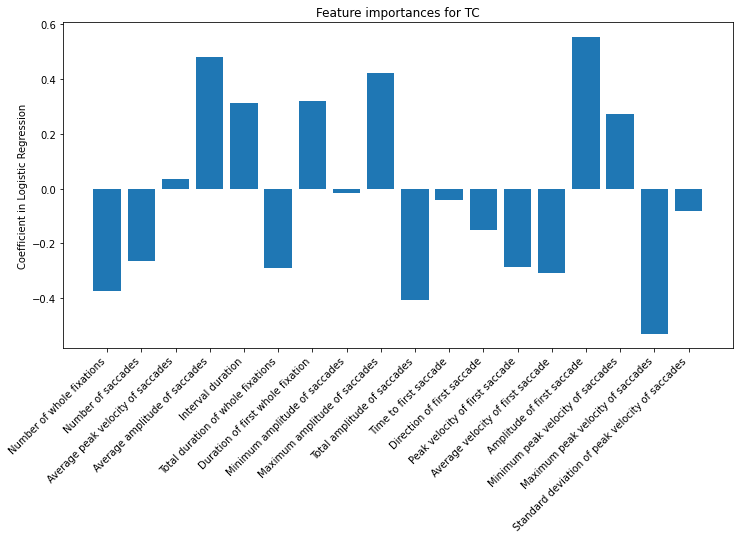

In [88]:
for j in range(len(clf.coef_)):
  #for i, coef in enumerate(clf_sel.coef_[j]):
    #print(f'{features.columns[selected_features[i]]}: ', '{0:.2f}'.format(coef))

  plt.figure(figsize=(12,6))
  plt.bar(features.columns, clf.coef_[j])
  plt.xticks(rotation=45, ha="right")
  plt.ylabel('Coefficient in Logistic Regression')
  plt.title('Feature importances for ' + le.inverse_transform([j])[0])
  plt.show()

## Random forest features importance

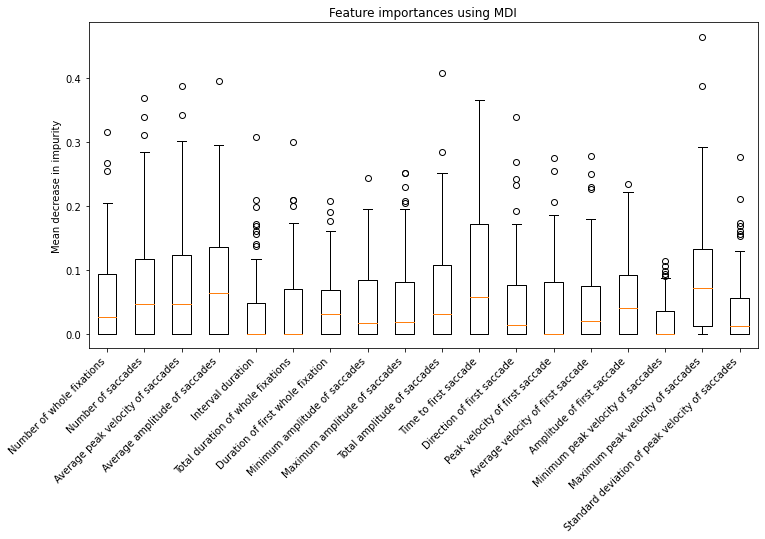

In [67]:
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features.columns)
tree_importances = pd.DataFrame([tree.feature_importances_ for tree in forest.estimators_], columns=features.columns)


plt.figure(figsize=(12,6))
#forest_importances.plot.bar(yerr=std)
plt.boxplot(tree_importances.T, labels=features.columns)
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.xticks(rotation=45, ha="right")
plt.show()

## Permutation feature importance

Average amplitude of saccades : 0.069 +/- 0.040
Maximum amplitude of saccades : 0.042 +/- 0.026
Amplitude of first saccade : 0.041 +/- 0.036
Total amplitude of saccades : 0.039 +/- 0.036
Peak velocity of first saccade : 0.035 +/- 0.021
Average velocity of first saccade : 0.035 +/- 0.024
Maximum peak velocity of saccades : 0.026 +/- 0.033
Total duration of whole fixations : 0.024 +/- 0.028
Number of whole fixations : 0.017 +/- 0.033
Duration of first whole fixation : 0.016 +/- 0.017
Number of saccades : 0.006 +/- 0.024
Time to first saccade : 0.006 +/- 0.015
Standard deviation of peak velocity of saccades : 0.002 +/- 0.012
Interval duration : 0.001 +/- 0.009
Minimum peak velocity of saccades : -0.000 +/- 0.011
Average peak velocity of saccades : -0.000 +/- 0.004
Minimum amplitude of saccades : -0.014 +/- 0.029
Direction of first saccade : -0.020 +/- 0.027


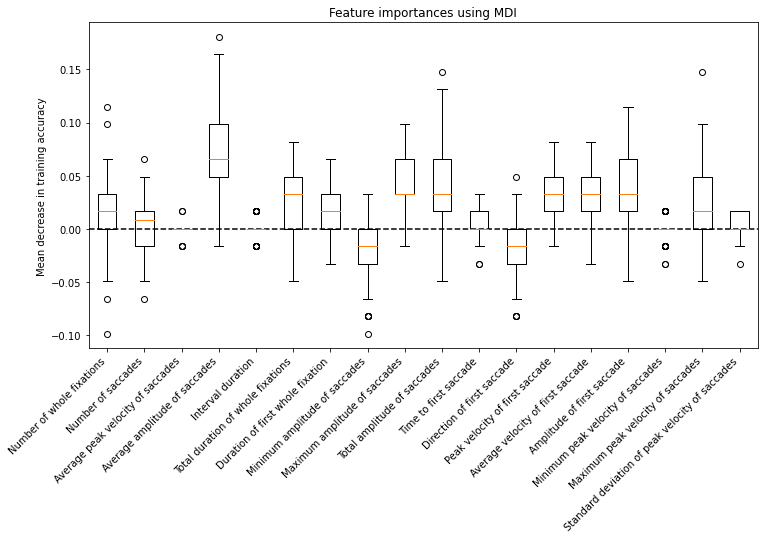

In [68]:
r = permutation_importance(clf, X, y,
                           n_repeats=100,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
      print(f"{features.columns[i]:<8} : "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")
    

plt.figure(figsize=(12,6))
plt.boxplot(r.importances.T, labels=features.columns)
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in training accuracy")
plt.xticks(rotation=45, ha="right")
plt.axhline(y=0, color="k", linestyle="--")
plt.show()

# Removing multicollinearity

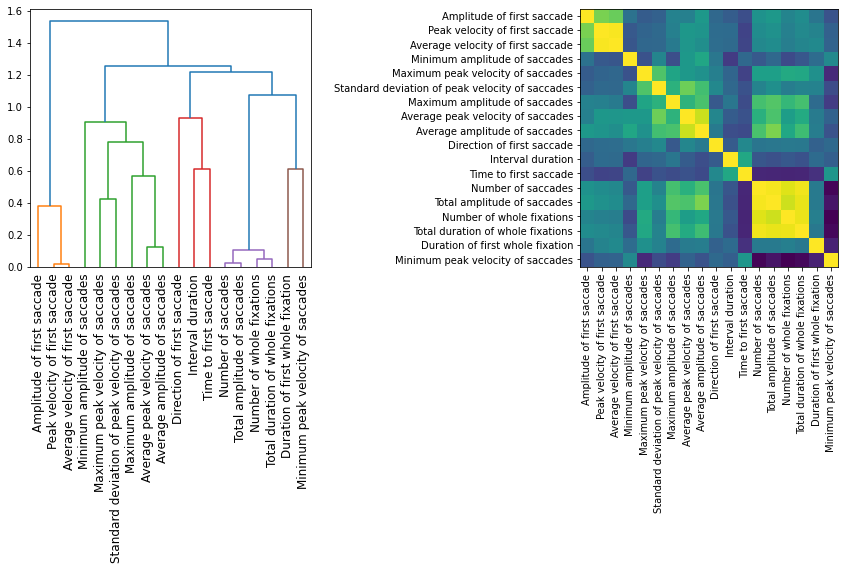

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=features.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [70]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.2, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_sel = X.iloc[:, selected_features]

clf_sel = LogisticRegression(class_weight='balanced')
clf_sel.fit(X_sel, y)
print("Accuracy with features removed: {:.2f}".format(clf_sel.score(X_sel, y)))

Accuracy with features removed: 0.66


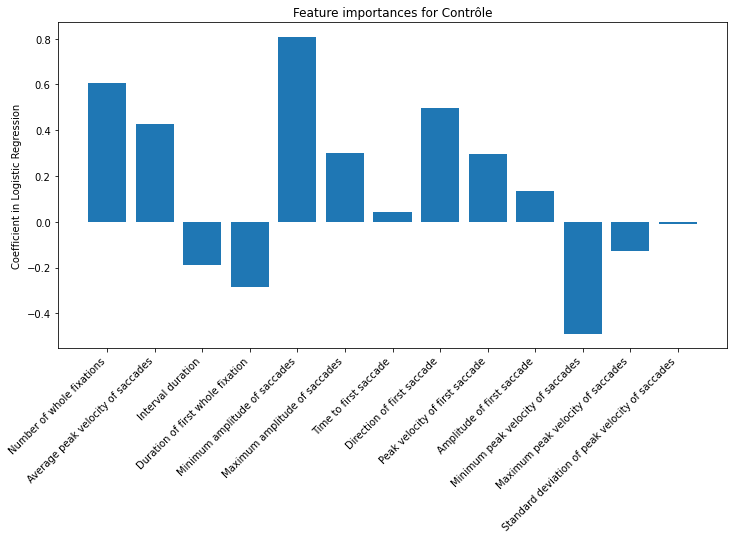

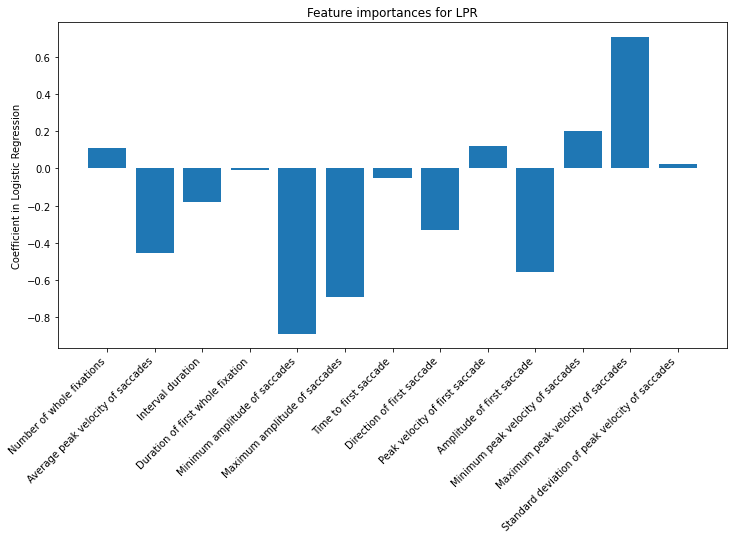

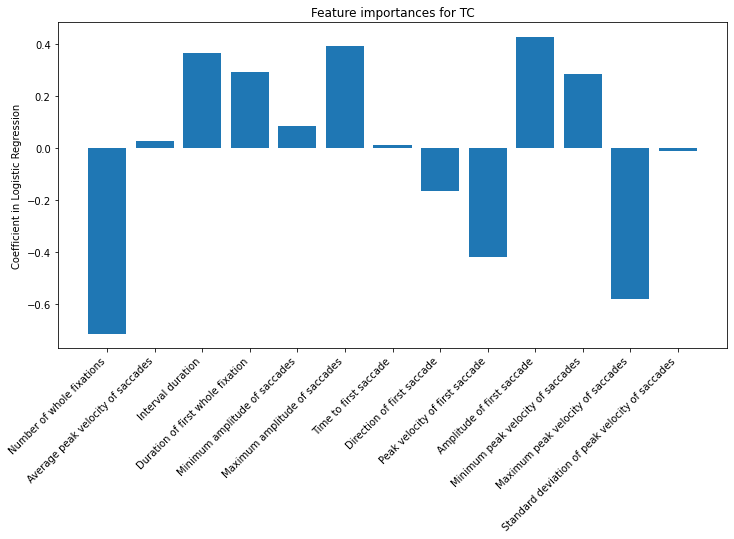

In [87]:
for j in range(len(clf_sel.coef_)):
  #for i, coef in enumerate(clf_sel.coef_[j]):
    #print(f'{features.columns[selected_features[i]]}: ', '{0:.2f}'.format(coef))

  plt.figure(figsize=(12,6))
  plt.bar(features.columns[selected_features], clf_sel.coef_[j])
  plt.xticks(rotation=45, ha="right")
  plt.ylabel('Coefficient in Logistic Regression')
  plt.title('Feature importances for ' + le.inverse_transform([j])[0])
  plt.show()

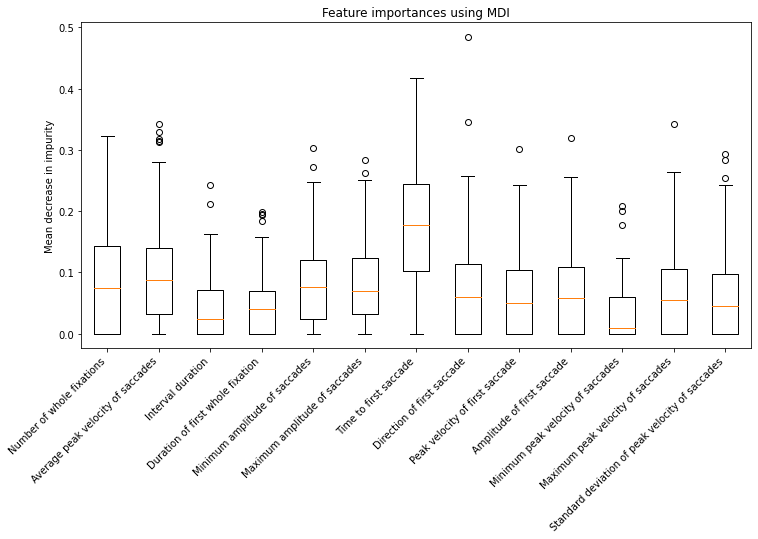

In [72]:
forest = RandomForestClassifier()
forest.fit(X_sel, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features.columns[selected_features])
tree_importances = pd.DataFrame([tree.feature_importances_ for tree in forest.estimators_], columns=features.columns[selected_features])


plt.figure(figsize=(12,6))
#forest_importances.plot.bar(yerr=std)
plt.boxplot(tree_importances.T, labels=features.columns[selected_features])
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.xticks(rotation=45, ha="right")
plt.show()

Number of whole fixations : 0.119 +/- 0.041
Interval duration : 0.101 +/- 0.047
Direction of first saccade : 0.099 +/- 0.031
Total duration of whole fixations : 0.096 +/- 0.033
Maximum amplitude of saccades : 0.063 +/- 0.033
Total amplitude of saccades : 0.062 +/- 0.036
Number of saccades : 0.043 +/- 0.039
Minimum amplitude of saccades : 0.041 +/- 0.037
Average amplitude of saccades : 0.024 +/- 0.022
Time to first saccade : 0.020 +/- 0.013
Duration of first whole fixation : 0.006 +/- 0.015
Peak velocity of first saccade : 0.003 +/- 0.010
Average peak velocity of saccades : 0.001 +/- 0.011


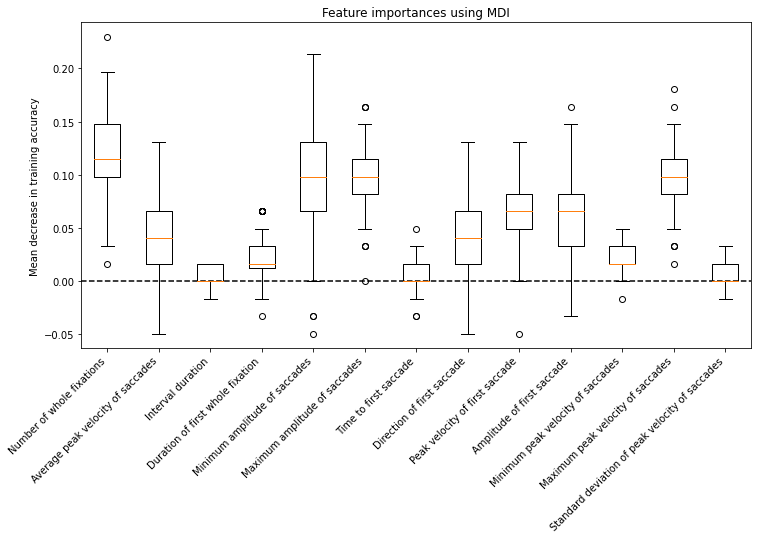

In [73]:
r = permutation_importance(clf_sel, X_sel, y,
                           n_repeats=100,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
      print(f"{features.columns[i]:<8} : "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")
    

plt.figure(figsize=(12,6))
plt.boxplot(r.importances.T, labels=features.columns[selected_features])
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in training accuracy")
plt.xticks(rotation=45, ha="right")
plt.axhline(y=0, color="k", linestyle="--")
plt.show()

# PCA

In [74]:
from sklearn.decomposition import PCA

In [75]:
pca = PCA(n_components=2).fit(X_sel)

# select the 5 most important features (with highest norm).
top_features_for_pca = np.linalg.norm(pca.components_, axis=0).argsort()[-5:]

for feature_ind in top_features_for_pca:
    msg = f"{features.columns[selected_features][feature_ind]}: {(pca.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

Maximum amplitude of saccades: 0.197
Peak velocity of first saccade: 0.208
Number of whole fixations: 0.215
Amplitude of first saccade: 0.304
Direction of first saccade: 0.496


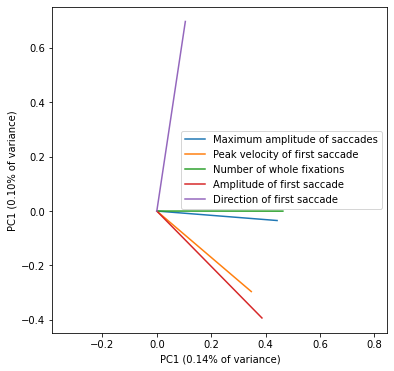

In [76]:
plt.figure(figsize=(6,6))
# plot the 2D projection of the top 5 features
for feature_ind in top_features_for_pca: # normaliser par la variance
    dx, dy = pca.components_.T[feature_ind]
    plt.plot([0, dx], [0, dy], label=features.columns[selected_features][feature_ind])
plt.xlabel(f"PC1 ({pca.explained_variance_[0]:.2f}% of variance)")
plt.ylabel(f"PC1 ({pca.explained_variance_[1]:.2f}% of variance)")
plt.axis('equal')
_ = plt.legend()